## Problema rellenar una mochila sin valores

In [2]:
import numpy as np
import torch

In [ ]:
def tensor_generator(pesos:np.array, valores:np.array, n_elementos:np.array, capacidad:int, tao:float, lambda1:float):
    lista_de_tensores = []
    n_clases = len(pesos)
    tensor = tensor_initial_generator(pesos[0],valores[0],n_elementos[0],capacidad,0,tao)

    lista_de_tensores.append(tensor)

    for node in range(1, n_clases-1):
        tensor = tensor_intermediate_generator(pesos[node], valores[node], n_elementos[node], capacidad, tensor.shape[1],tao)
        lista_de_tensores.append(tensor)

    tensor = tensor_final_generator(pesos[-1], valores[-1], n_elementos[-1], capacidad, tensor.shape[1],tao, lambda1)
    lista_de_tensores.append(tensor)

    return lista_de_tensores



In [4]:
def tensor_initial_generator(peso:int, valor:int, n_elementos:int, capacidad:int, previous_weight_solution:int,tao)->np.array:
    """
    Funcion que genera el tensor inicial.
    """
    tamaño_1 = min((capacidad-previous_weight_solution)//peso,n_elementos)+1
    tamaño_2 = min(capacidad, (tamaño_1-1)*peso+previous_weight_solution)+1
    tensor = np.zeros((tamaño_1,tamaño_2),dtype = complex)
    for i in range(tamaño_1):
        elemento = i*peso + previous_weight_solution
        tensor[i][elemento] = np.exp(tao*valor*i)*np.exp(1j*2*np.pi*i/tamaño_1)
    return tensor

In [5]:
def tensor_intermediate_generator(peso:int, valor:int, n_elementos:int, capacidad:int, previous_weight:int,tao:float)->np.array:

    tamaño_1 = previous_weight
    tamaño_2 = min(capacidad, n_elementos*peso+previous_weight-1)+1
    tensor = np.zeros((tamaño_1,tamaño_2),dtype = complex)
    for i in range(tamaño_1):
        n_elementos_restantes = min((capacidad -i)//peso,n_elementos)+1
        for  j in range(n_elementos_restantes):
            elemento = i + j*peso
            tensor[i][elemento] = np.exp(tao*valor*j)*np.exp(1j*2*np.pi/n_elementos_restantes)**j

    return tensor

In [6]:
def tensor_final_generator(peso:int, valor:int,n_elementos: int, capacidad: int, previous_weight:int, tao:float, lambda1:float)->np.array:
    tamaño_1 = previous_weight
    tensor = np.zeros((tamaño_1),dtype = complex)
    for i in range(tamaño_1):
        n_elementos_posibles = min((capacidad -i)//peso,n_elementos)+1
        for j in range(n_elementos_posibles):
            elemento = i +j*peso
            tensor[i] += np.exp(tao*j*valor)*np.exp(1j*2*np.pi*j/n_elementos_posibles)
            #tensor[i] += np.exp(-tao*(capacidad - elemento))
            #tensor[i] += np.exp(-lambda1*(capacidad - elemento))
    return tensor

In [ ]:
def tensor_contraction(lista_de_tensores:list):

    n_tensores = len(lista_de_tensores)
    tensores_intermedios = []
    vector = lista_de_tensores[-1]
    tensores_intermedios.append(vector)
    for j in range(n_tensores-1,0,-1):
        vector = lista_de_tensores[j-1] @ vector
        #(if max(vector) > 1e200:
            #vector = vector*1e-25
        tensores_intermedios.append(vector)
    tensores_intermedios.reverse()
    return vector,tensores_intermedios
    
'''
def tensor_contraction(lista_de_tensores):
    # Convertimos los tensores a tensores de PyTorch y movemos todo a la GPU
    lista_de_tensores = [torch.tensor(tensor, device='cuda') for tensor in lista_de_tensores]
    
    n_tensores = len(lista_de_tensores)
    tensores_intermedios = []
    vector = lista_de_tensores[-1]
    tensores_intermedios.append(vector)
    
    for j in range(n_tensores - 1, 0, -1):
        if j == n_tensores - 1:
            vector = lista_de_tensores[j - 1] @ vector.T
        else:
            vector = lista_de_tensores[j - 1] @ vector
        
        # Escalado para evitar overflow
        if torch.max(vector) > 1e200:
            vector = vector * 1e-15
        tensores_intermedios.append(vector)
    
    # Movemos los tensores intermedios a la CPU para su uso posterior si es necesario
    tensores_intermedios = [tensor.cpu().numpy() for tensor in tensores_intermedios]
    vector = vector.cpu().numpy()
    
    # Invertimos el orden de los tensores intermedios y devolvemos el resultado
    tensores_intermedios.reverse()
    return vector, tensores_intermedios
'''

"\ndef tensor_contraction(lista_de_tensores):\n    # Convertimos los tensores a tensores de PyTorch y movemos todo a la GPU\n    lista_de_tensores = [torch.tensor(tensor, device='cuda') for tensor in lista_de_tensores]\n    \n    n_tensores = len(lista_de_tensores)\n    tensores_intermedios = []\n    vector = lista_de_tensores[-1]\n    tensores_intermedios.append(vector)\n    \n    for j in range(n_tensores - 1, 0, -1):\n        if j == n_tensores - 1:\n            vector = lista_de_tensores[j - 1] @ vector.T\n        else:\n            vector = lista_de_tensores[j - 1] @ vector\n        \n        # Escalado para evitar overflow\n        if torch.max(vector) > 1e200:\n            vector = vector * 1e-15\n        tensores_intermedios.append(vector)\n    \n    # Movemos los tensores intermedios a la CPU para su uso posterior si es necesario\n    tensores_intermedios = [tensor.cpu().numpy() for tensor in tensores_intermedios]\n    vector = vector.cpu().numpy()\n    \n    # Invertimos el o

In [1]:
from time import time
from scipy.sparse import csr_matrix
def solver(pesos:np.array, valores:np.array, n_elementos:np.array, capacidad:int, tao:float, lambda1:float)->np.array:
    """
    Funcion que resuelve el problema de la mochila sin valores.
    """ 
    n_clases = len(pesos)
    solution = np.zeros(n_clases)
  
    lista_de_tensores = tensor_generator(pesos, valores, n_elementos, capacidad, tao, lambda1)
    for t in lista_de_tensores:
        print("t")
        print(t)
        
 
    vector_salida, tensores_intermedios = tensor_contraction(lista_de_tensores)

 
    max = np.max(tensores_intermedios[0])
  
    solution[0] = np.argmax(abs(vector_salida))



    for n in range(1,n_clases-1):
        cuenta_peso = int(np.dot(solution[:n],pesos[:n]))
        new_initial_tensor = tensor_initial_generator(pesos[n], valores[n], n_elementos[n], capacidad, cuenta_peso,tao)

        solution[n]= np.argmax(abs(new_initial_tensor @ tensores_intermedios[n+1][:new_initial_tensor.shape[1]]))
   

    cuenta_peso = np.dot(solution[:-1],pesos[:-1])
    solution[-1] = min((capacidad-cuenta_peso)//pesos[-1],n_elementos[-1])
    print("La solucion es: ", solution)
    print("El peso total es: ", np.dot(solution,pesos))
    print("El valor total es: ", np.dot(solution,valores))
    return np.dot(solution,pesos),np.dot(solution,valores),max

NameError: name 'np' is not defined

In [88]:
clases = 100
capacidad =1000
np.random.seed(1)
pesos = np.random.randint(1,10,clases)
#print(pesos)
valores = np.random.rand(clases)
#print(valores)
n_elementos = [1]*clases


tao = 1
lambda1 = 1

b,c,g=solver(pesos,valores, n_elementos, capacidad, tao, lambda1)


t
[[ 1.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j
  -1.07658287+1.31843376e-16j]]
t
[[ 1.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j -2.19668954+2.69016882e-16j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  1.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0

In [10]:

def mochila_greedy(pesos, valores, capacidad, n_elementos):
    n_clases = len(pesos)
    
    # Calculamos la relación valor/peso para cada clase
    valor_peso = valores / pesos
    
    # Ordenamos los elementos por su valor/peso de mayor a menor
    indices_ordenados = np.argsort(valor_peso)[::-1]  # Orden descendente
    
    # Inicializamos variables
    peso_actual = 0
    valor_actual = 0
    solucion = np.zeros(n_clases, dtype=int)
    
    # Recorremos los objetos en orden greedy
    for i in indices_ordenados:
        # Tomamos la mayor cantidad posible de este objeto sin exceder la capacidad
        cantidad = min(n_elementos[i], (capacidad - peso_actual) // pesos[i])
        solucion[i] = cantidad
        peso_actual += cantidad * pesos[i]
        valor_actual += cantidad * valores[i]
        
        # Si llenamos la capacidad, salimos del bucle
        if peso_actual >= capacidad:
            break
    
    return solucion, valor_actual

# Ejecutamos el algoritmo

mejor_solucion, mejor_valor = mochila_greedy(pesos, valores, capacidad, n_elementos)

print("Mejor solución encontrada (greedy):", mejor_solucion)
print("Valor total de la mejor solución (greedy):", mejor_valor)
print("Peso total de la mejor solución (greedy):", np.sum(mejor_solucion * pesos))
#print(b==mejor_valor)

Mejor solución encontrada (greedy): [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valor total de la mejor solución (greedy): 43.813943012269455
Peso total de la mejor solución (greedy): 523


## Dependencia del resultado con el número de clases y con el tao

In [11]:
import matplotlib.pyplot as plt
import random
def tao_experimento(clases,capacidad,pesos,valores,n_elementos,tao,lambda1,experimento):
   precision=[]
   max_values=[]
   for t in tao:

      p1,v1,max=solver(pesos,valores,n_elementos,capacidad,t,lambda1)

      p2,v2 = mochila_greedy(pesos,valores,capacidad,n_elementos)

      precision.append(v1/v2)
      max_values.append(max)
   random_color = (random.random(), random.random(), random.random())
   plt.plot(tao, precision, marker='o', color=random_color, linestyle='-')  # 'o' para puntos, 'b' para color azul, '-' para línea sólida
   plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.8)
   # Añadir etiquetas y título
   plt.xlabel(r"$\tau$")
   plt.ylabel("precision")
   plt.title("Gráfico de línea con dos listas")
   plt.savefig(f"grafico_precision_{experimento}.png", format="png", dpi=300)


   return precision,max_values
'''
clases = 200
capacidad = 1212
np.random.seed(1)
pesos = np.random.randint(1,10,clases)
valores = np.random.rand(clases)
n_elementos = [1]*clases
tao = np.linspace(0,8,30)

lambda1 = 0
exp=1
#precision,max_values=tao_experimento(clases,capacidad,pesos,valores,n_elementos,tao,lambda1,exp)
for exp in range(10,41):
   clases = 1+exp*20
   capacidad = 1212
   np.random.seed(1)
   pesos = np.random.randint(1,10,clases)
   valores = np.random.rand(clases)
   n_elementos = [1]*clases
   tao = np.linspace(0,8,30)
   precision,max_values=tao_experimento(clases,capacidad,pesos,valores,n_elementos,tao,lambda1,exp)
'''


'\nclases = 200\ncapacidad = 1212\nnp.random.seed(1)\npesos = np.random.randint(1,10,clases)\nvalores = np.random.rand(clases)\nn_elementos = [1]*clases\ntao = np.linspace(0,8,30)\n\nlambda1 = 0\nexp=1\n#precision,max_values=tao_experimento(clases,capacidad,pesos,valores,n_elementos,tao,lambda1,exp)\nfor exp in range(10,41):\n   clases = 1+exp*20\n   capacidad = 1212\n   np.random.seed(1)\n   pesos = np.random.randint(1,10,clases)\n   valores = np.random.rand(clases)\n   n_elementos = [1]*clases\n   tao = np.linspace(0,8,30)\n   precision,max_values=tao_experimento(clases,capacidad,pesos,valores,n_elementos,tao,lambda1,exp)\n'

# Dependencia del resultado con distintos ordenamientos de los pesos

[0.07379201 0.78695147 0.06406733 0.35531036 0.94183695 0.37980329
 0.76292007 0.771595   0.3013605  0.77273915 0.15292982 0.57863393
 0.009008   0.70904252 0.47064081 0.76459257 0.46739268 0.26900105
 0.83169259 0.55132494 0.0700815  0.47247504 0.74276483 0.19195608
 0.4643115  0.23036281 0.50824754 0.20856831 0.04930424 0.51886188
 0.17227835 0.39631329 0.1073653  0.50981028 0.10213523 0.28871783
 0.23175846 0.96766793 0.27831884 0.23362252 0.09155644 0.57006666
 0.41792654 0.36784324 0.81299497 0.28976    0.7173916  0.61294809
 0.42690983 0.75187297 0.42781263 0.42838241 0.36190444 0.15333848
 0.93719032 0.91640987 0.78195846 0.61632895 0.03599944 0.65432377
 0.12976961 0.29435948 0.36081475 0.27464515 0.07396899 0.15213716
 0.16161852 0.9387117  0.3711339  0.05001809 0.74095556 0.29868024
 0.20435813 0.98175664 0.89302121 0.75934879 0.65112056 0.0396835
 0.81387637 0.76257313 0.45528247 0.53182645 0.10933607 0.14603275
 0.50878874 0.21565028 0.9164437  0.46215251 0.13226727 0.76424

/tmp/ipykernel_1033/3173318684.py:8: RuntimeWarning: overflow encountered in matmul
  vector = lista_de_tensores[j-1] @ vector
/tmp/ipykernel_1033/3173318684.py:8: RuntimeWarning: invalid value encountered in matmul
  vector = lista_de_tensores[j-1] @ vector
/tmp/ipykernel_1033/3464046430.py:24: RuntimeWarning: overflow encountered in matmul
  solution[n]= np.argmax(abs(new_initial_tensor @ tensores_intermedios[n+1][:new_initial_tensor.shape[1]]))
/tmp/ipykernel_1033/3464046430.py:24: RuntimeWarning: invalid value encountered in matmul
  solution[n]= np.argmax(abs(new_initial_tensor @ tensores_intermedios[n+1][:new_initial_tensor.shape[1]]))
/tmp/ipykernel_1033/3464046430.py:24: RuntimeWarning: overflow encountered in absolute
  solution[n]= np.argmax(abs(new_initial_tensor @ tensores_intermedios[n+1][:new_initial_tensor.shape[1]]))


La solucion es:  [0. 0. 0. 1. 5. 5. 0. 0. 0. 5. 0. 5. 0. 5. 0. 0. 0. 0. 0. 5. 0. 0. 0. 0.
 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 5. 5. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 5. 5. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 5. 5.
 0. 3. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 5. 2. 0. 0. 0. 0. 0. 5. 0.
 0. 5. 4. 5.]
El peso total es:  345.0
El valor total es:  78.20160207308602
La solucion es:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0.
 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 0. 5. 5. 5. 5. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 5. 5. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 5. 5.
 0. 5. 5. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 5. 4. 4. 0. 0. 0. 0. 0. 5. 0.
 0. 5. 5. 5.]
El peso total es:  345.0
El valor total es:  70.27777584201729
[(-1.323170995934608e+37+5.596889358570685e+36j), (-1.9385348888867966e+61-1.067234820473419e+60j), (8.779512364561879e+95+1.394420429091006e+95j), (-4.047299524098733e+123+5.395721384460926e+123j), (2.1703722597858745e+165-1.27

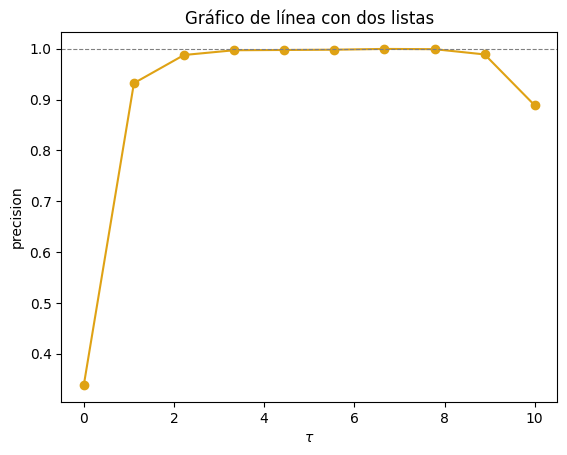

In [12]:
clases = 100
capacidad = 345
np.random.seed(1)
pesos = np.random.randint(1,10,clases)
valores = np.random.rand(clases)
print(valores)
n_elementos = [5]*clases
tao = np.linspace(0,10,10)

lambda1 = 0
exp=1
precision,max_values=tao_experimento(clases,capacidad,pesos,valores,n_elementos,tao,lambda1,exp)
print(max_values)

In [13]:
print(max_values)

[(-1.323170995934608e+37+5.596889358570685e+36j), (-1.9385348888867966e+61-1.067234820473419e+60j), (8.779512364561879e+95+1.394420429091006e+95j), (-4.047299524098733e+123+5.395721384460926e+123j), (2.1703722597858745e+165-1.278293929256209e+165j), (3.3198412252046795e+201+1.5653767352960603e+201j), (9.74677662066227e+237+1.3790411471257447e+238j), (5.757205296907291e+274+1.5748285327342947e+275j), (nan+nanj), (nan+nanj)]


/home/sergio/simulador/Simulador_Cuantica/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/sergio/simulador/Simulador_Cuantica/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Gráfico de línea con dos listas')

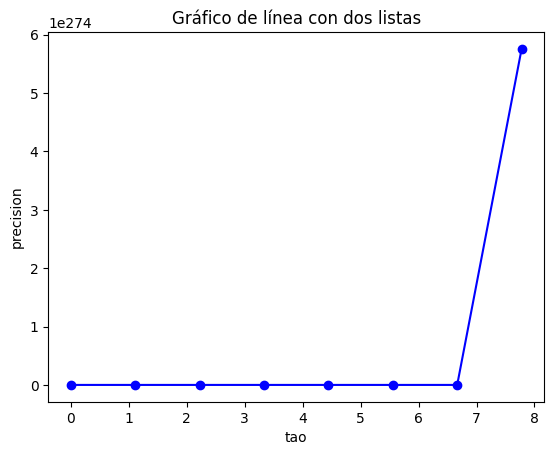

In [14]:
plt.plot(tao, max_values, marker='o', color='b', linestyle='-')  # 'o' para puntos, 'b' para color azul, '-' para línea sólida
# Añadir etiquetas y título
plt.xlabel("tao")
plt.ylabel("precision")
plt.title("Gráfico de línea con dos listas")